In [20]:
import pandas as pd

df_action = pd.read_csv('/Users/vladimirbaranov/Downloads/Action.csv')
df_action

,uid,Ts,Action
0,cfjqq,2020-01-16 09:24:32,firstOpen
1,cfjqq,2020-01-16 15:39:41,function2
2,cfjqq,2020-01-16 15:58:21,function4
3,hclau,2020-01-10 22:54:42,firstOpen
4,hclau,2020-01-11 01:19:03,function1
...,...,...,...
185184,stlku,2020-01-15 23:34:13,function4
185185,bueap,2020-01-16 08:08:30,firstOpen
185186,bueap,2020-01-16 23:28:50,function1
185187,bueap,2020-01-16 14:53:53,function3


In [50]:
df_action['Action'].value_counts()

Action
firstOpen    50001
function4    40102
function3    40030
function2    27585
function1    27471
Name: count, dtype: int64

In [40]:
df_exp = pd.read_csv('/Users/vladimirbaranov/Downloads/Experiments.csv')
df_exp = df_exp[df_exp['Experiment'] == 'paymentChange']
df_exp

,Experiment,Group,uid
50001,paymentChange,Old,cfjqq
50002,paymentChange,Old,hclau
50003,paymentChange,Old,bkhtq
50004,paymentChange,Old,rxxdh
50005,paymentChange,Old,ccsko
...,...,...,...
99997,paymentChange,New,xirhh
99998,paymentChange,New,eqkvn
99999,paymentChange,New,habsc
100000,paymentChange,New,jawkx


In [4]:
df_pay = pd.read_csv('/Users/vladimirbaranov/Downloads/Payment.csv')
df_pay

,uid,paymentType,Payment
0,hclau,type1,400
1,hclau,type2,200
2,bkhtq,type2,200
3,rxxdh,type2,200
4,qxjhx,type1,400
...,...,...,...
36053,hfrqg,type2,200
36054,kdcrn,type2,200
36055,pohbf,type2,200
36056,stlku,type1,160


`Action.csv` - Здесь данные о действиях, которые совершил пользователь в определнное время

`Experiments.csv` - Здесь находится информация о тестах проводимых в данное время. Всего их два, нас интересует paymentChange. В том эксперименте пользователи распределены буквально идеально на тест и контроль. Айдишники все уникальные. Юзеров, которые попали в оба эксперимента нету.

`Payment.csv` - Здесь данные о транзакциях. Type1 - оплата подписки (160 или 400). Type2 - сторонняя покупка

In [14]:
df_pay['Payment'].value_counts()

Payment
200    18621
160    12469
400     4968
Name: count, dtype: int64

# Сначала выполним ряд проверок наших данных

### 1. Проверка корректности сплитования

In [48]:
# 1.1 Равномерность по количеству пользователей
payment_change_df = df_exp
payment_change_df["Group"].value_counts()

Group
Old    25001
New    25000
Name: count, dtype: int64

In [49]:
# 1.2 Пересечения между группами
grouped = payment_change_df.groupby("uid")["Group"].nunique()
crossed_users = grouped[grouped > 1]
print(f"Пересекающихся пользователей: {len(crossed_users)}")

Пересекающихся пользователей: 0


In [54]:
# 1.3 Равномерность по действиям (например, firstOpen)
df_action["Ts"] = pd.to_datetime(df_action["Ts"])
action_before = df_action[df_action["Ts"] < pd.Timestamp("2020-01-09")]  # дата старта - 2020.01.09
app_open = action_before[action_before["Action"] == "firstOpen"]
app_open = app_open.merge(payment_change_df, on="uid", how="inner")
print(app_open.groupby("Group")["uid"].nunique())

Series([], Name: uid, dtype: int64)


In [55]:
# 1.4 Проверка уникальности uid в каждой группе
print("Уникальных пользователей:\n", payment_change_df.groupby("Group")["uid"].nunique())

Уникальных пользователей:
 Group
New    25000
Old    25001
Name: uid, dtype: int64


**Здесь всё хорошо**

### 2.Проверяем периоды и даты

In [56]:
# 2.1 Диапазон дат в Action
print("Action timestamps:", df_action["Ts"].min(), "—", df_action["Ts"].max())

Action timestamps: 2020-01-09 19:00:27 — 2020-01-20 18:50:42


In [57]:
# 2.2 Диапазон дат платежей по группам
payment_change_merged = payment_change_df.merge(df_pay, on="uid", how="left")
payment_change_merged["date"] = pd.to_datetime(df_action["Ts"], errors="coerce")
print(payment_change_merged.groupby("Group")["date"].agg(["min", "max"]))

                      min                 max
Group                                        
New   2020-01-09 19:01:14 2020-01-20 18:23:02
Old   2020-01-09 19:00:27 2020-01-20 18:40:54


In [58]:
# 2.3 Проверка пересечений uid и с другими экспериментами
experiments_per_uid = df_exp.groupby("uid")["Experiment"].nunique()
multi_experiments = experiments_per_uid[experiments_per_uid > 1]
print(f"Пользователей в нескольких экспериментах: {len(multi_experiments)}")

Пользователей в нескольких экспериментах: 0


**Здесь тоже всё хорошо**

### 3.Теперь сделаем проверку распределения данных

Решил попробовать отразить распределение с помощью линии :)

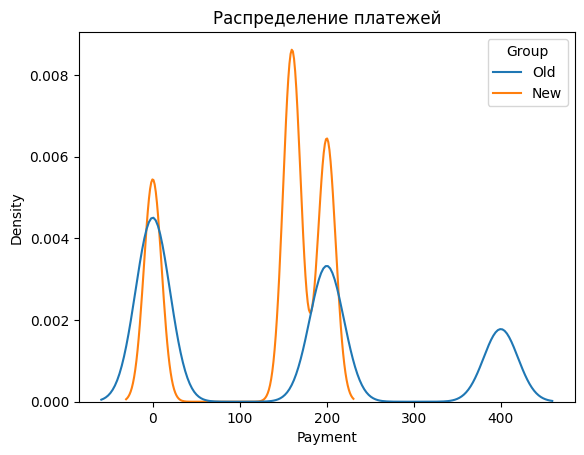

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3.1 Распределение ARPU
payment_change_merged["Payment"] = payment_change_merged["Payment"].fillna(0)
sns.kdeplot(data=payment_change_merged, x="Payment", hue="Group")
plt.title("Распределение платежей")
plt.show()

Поскольку мы имеем дело с тремя метриками конверсии и все они у нас бинарные, будеим проверять результаты с помощью Z-теста. И того мы будем сравнивать три пары метрик - три теста

In [68]:
from statsmodels.stats.proportion import proportions_ztest

# Объединение и подготовка
merged = payment_change_df.merge(df_pay, on="uid", how="left")
merged["Payment"] = merged["Payment"].fillna(0)
merged["paymentType"] = merged["paymentType"].fillna("none")

pivot = merged.pivot_table(index="uid", columns="paymentType", values="Payment", aggfunc="sum", fill_value=0).reset_index()
pivot["subscribed"] = pivot["type1"] > 0
pivot["purchased"] = pivot["type2"] > 0
pivot = pivot.merge(payment_change_df[["uid", "Group"]], on="uid", how="left")

def binary_ztest(success1, n1, success2, n2, label):
    stat, pval = proportions_ztest([success1, success2], [n1, n2])
    conv1 = round(success1 / n1, 3)
    conv2 = round(success2 / n2, 3)
    
    print(f"\n {label}")
    print(f" Old (до): {success1}/{n1} = {conv1}")
    print(f" New (после): {success2}/{n2} = {conv2}")
    print(f" z-статистика: {stat:.3f}")
    print(f" p-value: {pval:.3f}")
    if pval < 0.05:
        print("Различие статистически значимо")
    else:
        print("Различие не является значимым")

# Тест 1: Конверсия в подписку
s_old = pivot[(pivot["Group"] == "Old") & (pivot["subscribed"])].shape[0]
n_old = pivot[pivot["Group"] == "Old"].shape[0]
s_new = pivot[(pivot["Group"] == "New") & (pivot["subscribed"])].shape[0]
n_new = pivot[pivot["Group"] == "New"].shape[0]
binary_ztest(s_old, n_old, s_new, n_new, "Конверсия в подписку")

# Тест 2: Конверсия в разовую покупку
s_old = pivot[(pivot["Group"] == "Old") & (pivot["purchased"])].shape[0]
s_new = pivot[(pivot["Group"] == "New") & (pivot["purchased"])].shape[0]
binary_ztest(s_old, n_old, s_new, n_new, "Конверсия в разовую покупку")

# Тест 3: Конверсия подписчиков в разовую покупку
sub_only = pivot[pivot["subscribed"]]
s_old = sub_only[(sub_only["Group"] == "Old") & (sub_only["purchased"])].shape[0]
n_old = sub_only[sub_only["Group"] == "Old"].shape[0]
s_new = sub_only[(sub_only["Group"] == "New") & (sub_only["purchased"])].shape[0]
n_new = sub_only[sub_only["Group"] == "New"].shape[0]
binary_ztest(s_old, n_old, s_new, n_new, "Конверсия подписчиков в разовую покупку")


 Конверсия в подписку
 Old (до): 4968/25001 = 0.199
 New (после): 12469/25000 = 0.499
 z-статистика: -70.392
 p-value: 0.000
Различие статистически значимо

 Конверсия в разовую покупку
 Old (до): 9293/25001 = 0.372
 New (после): 9328/25000 = 0.373
 z-статистика: -0.327
 p-value: 0.744
Различие не является значимым

 Конверсия подписчиков в разовую покупку
 Old (до): 1850/4968 = 0.372
 New (после): 4678/12469 = 0.375
 z-статистика: -0.343
 p-value: 0.731
Различие не является значимым


## Результаты

Снижение цены подписки дало колоссальный рост конверсии. Мы увидели рост почти в 2.5 раза. Это статистически значимо и коммерчески мощно. 

В дальнейшем стоит раскатить это на всех пользователей. Стоит посчитать Ltv - возможно такая цена нам даст в дальнейшем большую выручку. 